# Titanic - Machine Learning from Disaster

## Overview

The sinking of the Titanic is one of the most infamous shipwrecks in history.

On April 15, 1912, during her maiden voyage, the widely considered “unsinkable” RMS Titanic sank after colliding with an iceberg. Unfortunately, there weren’t enough lifeboats for everyone onboard, resulting in the death of 1502 out of 2224 passengers and crew.

While there was some element of luck involved in surviving, it seems some groups of people were more likely to survive than others.

In this challenge, the goal is to build a predictive model that answers the question: “what sorts of people were more likely to survive?” using passenger data (ie name, age, gender, socio-economic class, etc).

### Problem Definition

> what sorts of people were more likely to survive?

### Data

The data has been split into two groups:

- training set (train.csv)
- test set (test.csv)

The training set was used to build the machine learning models. For the training set, it provides the outcome (also known as the “ground truth”) for each passenger. The model was based on “features” like passengers’ gender and class. 

The test set was used to see how well the model performed on unseen data. For each passenger in the test set, the model was trained to predict whether or not they survived the sinking of the Titanic.

Also includes is the gender_submission.csv, a set of predictions that assume all and only female passengers survive, as an example of what the submission file should look like.

For more details, checkout the [data dictionary](https://www.kaggle.com/competitions/titanic/data)

### Evaluation

> The score is the percentage of passengers the model correctly predicted. This is known as accuracy.

### Features
#### Data Analysis EDA

In [1]:
# import libraries
import numpy as np
import matplotlib.pyplot as plt 
import pandas as pd 
from sklearn.metrics import accuracy_score 
from sklearn.ensemble import RandomForestClassifier 
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.preprocessing import OneHotEncoder
import optuna as opt
import xgboost as xgb
import catboost as cat
%matplotlib inline

In [2]:
# load data 
df = pd.read_csv('data/train.csv')
df.sample(frac=.2)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
40,41,0,3,"Ahlin, Mrs. Johan (Johanna Persdotter Larsson)",female,40.0,1,0,7546,9.4750,NaN,S
430,431,1,1,"Bjornstrom-Steffansson, Mr. Mauritz Hakan",male,28.0,0,0,110564,26.5500,C52,S
216,217,1,3,"Honkanen, Miss. Eliina",female,27.0,0,0,STON/O2. 3101283,7.9250,NaN,S
343,344,0,2,"Sedgwick, Mr. Charles Frederick Waddington",male,25.0,0,0,244361,13.0000,NaN,S
627,628,1,1,"Longley, Miss. Gretchen Fiske",female,21.0,0,0,13502,77.9583,D9,S
...,...,...,...,...,...,...,...,...,...,...,...,...
73,74,0,3,"Chronopoulos, Mr. Apostolos",male,26.0,1,0,2680,14.4542,NaN,C
845,846,0,3,"Abbing, Mr. Anthony",male,42.0,0,0,C.A. 5547,7.5500,NaN,S
267,268,1,3,"Persson, Mr. Ernst Ulrik",male,25.0,1,0,347083,7.7750,NaN,S
18,19,0,3,"Vander Planke, Mrs. Julius (Emelia Maria Vande...",female,31.0,1,0,345763,18.0000,NaN,S


In [3]:
# check that the `Passengerid` feature is unique for all samples
df['PassengerId'].value_counts().sum() , df.shape[0]

(np.int64(891), 891)

In [4]:
# quick overview of the dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


Note: 
- There are 891 samples/rows and 12 columns/varibles (11 features, 1 label).
- There are some non-numeric features.
- Based on the total number of rows there are some missing values in some features like `Age`, `Cabin`...

In [5]:
# check dimension of data
df.shape 

(891, 12)

In [6]:
# check that labels have only 2 unique values
df.Survived.value_counts() 

Survived
0    549
1    342
Name: count, dtype: int64

In [7]:
# quick descriptive statistics
df.describe() 

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


Note:
- The majority of passengers came with at least one person (sibling, spouse, parent, or child)
- There seem to be an outlier in the `Age` column - `0.42  `, need to visualize to comfirm. Might be an outlier, or a toddler i.e 42% of 12 (couple of months old).
- Seems some person's did not pay for the fare, min value is `0` might be crew members, need to visualize.
- Less passengers survived.
- The majority of passengers bought 3rd class tickets. 
- The majority of passegers were young adults less than 40 years of age.

### Data Visualization

In [8]:
df.head(2)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C


In [9]:
df.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')

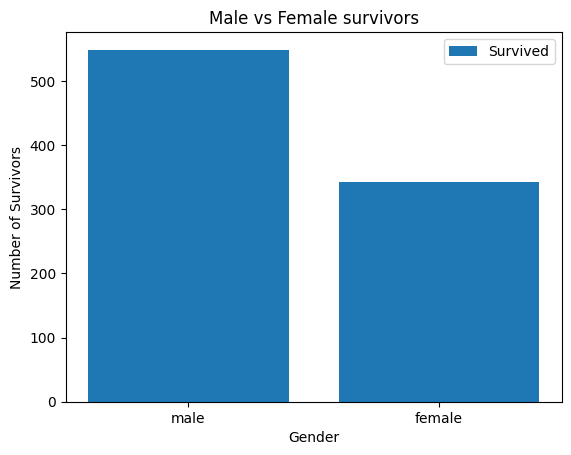

In [10]:
# check the number of survivors with respect to gender 
fig, ax = plt.subplots()
ax.bar(df.Sex.unique(), df.Survived.value_counts(), label='Survived');
ax.set(xlabel='Gender',
       ylabel='Number of Survivors',
       title="Male vs Female survivors")
ax.legend();


In [11]:
df.head(2)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C


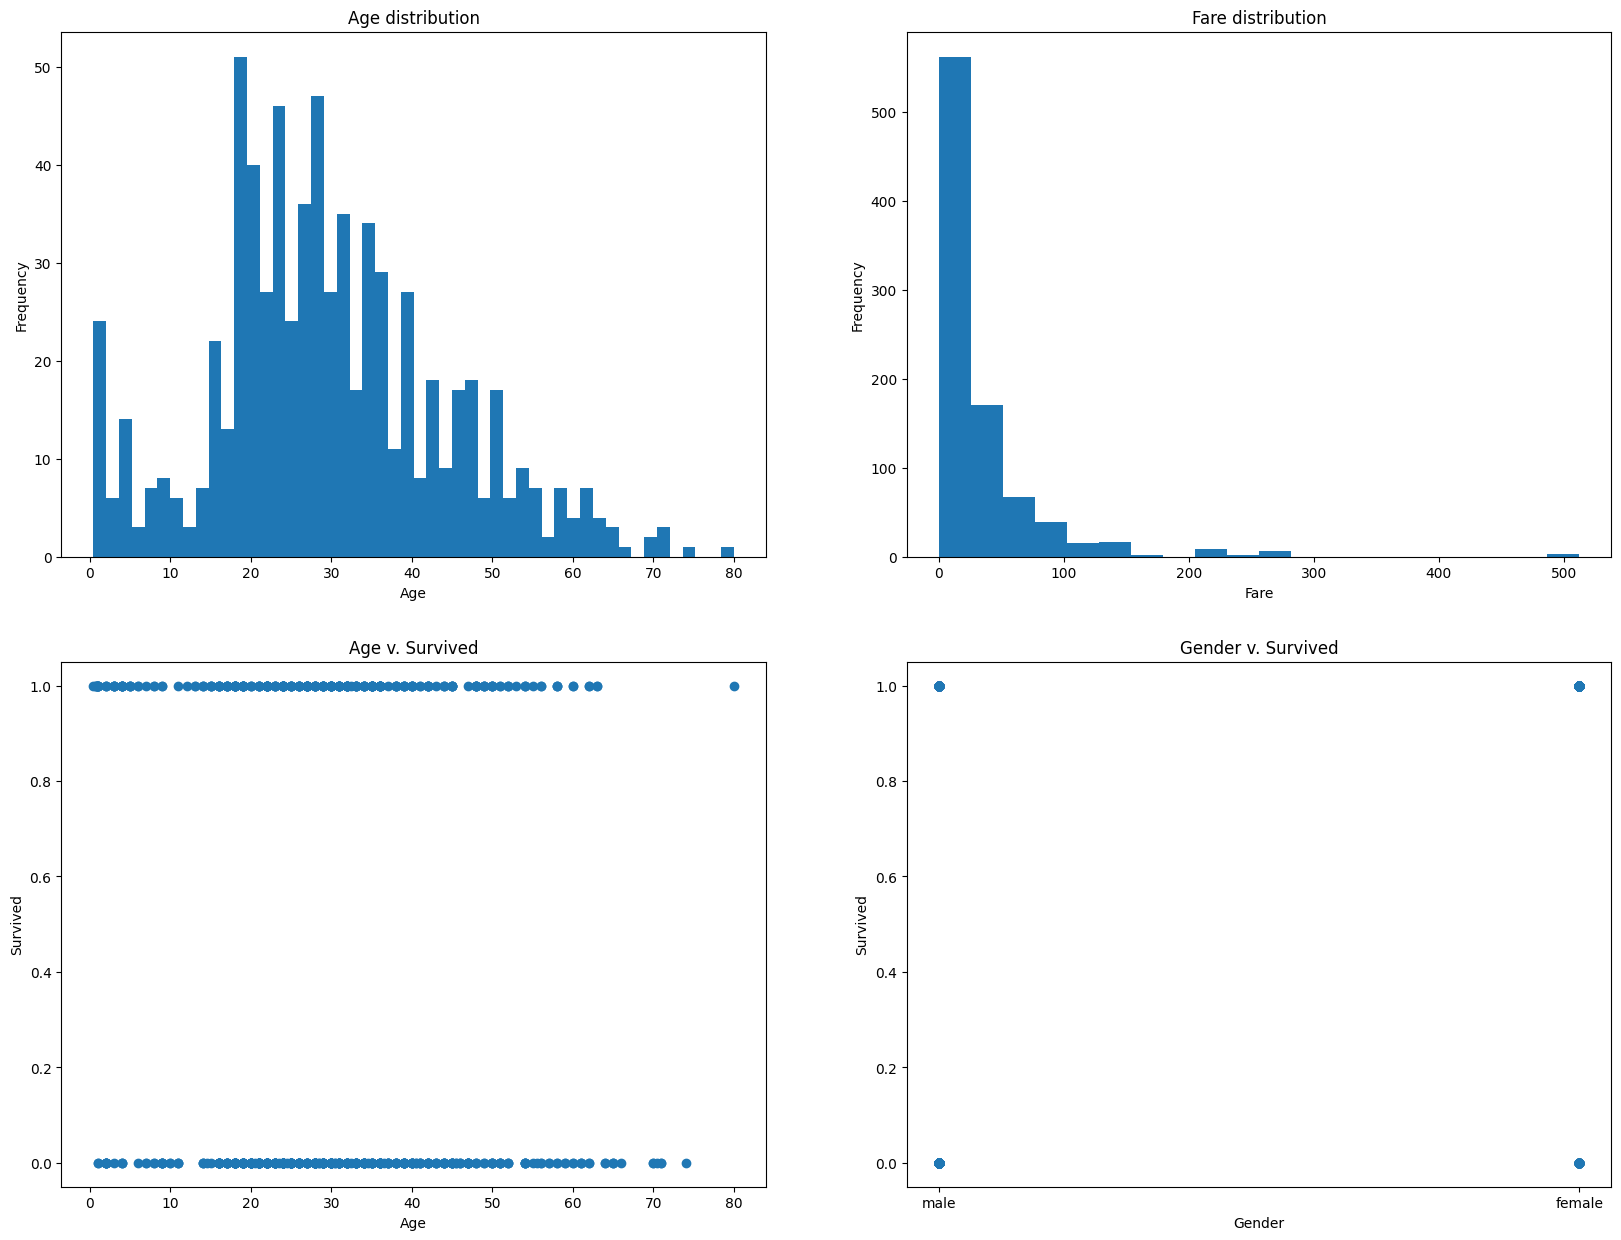

In [12]:
# age distribution, fare distribution, scatter plot between age and survival, gender and survival
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2, figsize=(20,15))
ax1.hist(df.Age, bins=50)
ax2.hist(df.Fare, bins=20)
ax3.scatter(df.Age, df.Survived)
ax4.scatter(df.Sex, df.Survived)

ax1.set(title='Age distribution',
        xlabel='Age',
        ylabel='Frequency')

ax2.set(title='Fare distribution',
        xlabel='Fare',
        ylabel='Frequency')

ax3.set(title='Age v. Survived',
        xlabel='Age',
        ylabel='Survived')

ax4.set(title='Gender v. Survived',
        xlabel='Gender',
        ylabel='Survived');


In [13]:
pd.crosstab(df.Sex, df.Survived.value_counts())

count,342,549
Sex,,
female,1,0
male,0,1


## Modelling

In [14]:
# duplicate df
df_mod = df.copy() 
df_mod.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


### Data Modelling EDA:  Preprocessing

In [15]:
# re-confirm if there are missing values in the dataset
df_mod.isna().sum() 

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [16]:
for label,content in df_mod.items():
    if content.isna().sum():
        print(label)

Age
Cabin
Embarked


There are missing values in 3 features

#### Address missing values

In [17]:
df_mod.head(2)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C


In [18]:
df_mod.Fare.unique().sum()

np.float64(10056.312600000001)

In [19]:
df_mod.Age.isna().sum(), len(df_mod)

(np.int64(177), 891)

Missing values will be filled accordingly:
- Age: Median and indicator column 
- Cabin: 'Missing' and indicator column
- Embarked: 'M' and indicator column 

In [20]:
# fix all missing values
for label,content in df_mod.items():
    if (label=='Age'):
         if pd.isna(content).sum():
                df_mod[label + '_is_missing'] = pd.isna(content)
                df_mod[label] = content.fillna(content.median())
    elif (label=='Cabin'):
         if pd.isna(content).sum():
              df_mod[label + '_is_missing'] = pd.isna(content)
              df_mod[label] = content.fillna('Missing')
    elif (label=='Embarked'):
         if pd.isna(content).sum():
              df_mod[label + '_is_missing'] = pd.isna(content)
              df_mod[label] = content.fillna('M') 

In [21]:
df_mod.isna().sum()

PassengerId            0
Survived               0
Pclass                 0
Name                   0
Sex                    0
Age                    0
SibSp                  0
Parch                  0
Ticket                 0
Fare                   0
Cabin                  0
Embarked               0
Age_is_missing         0
Cabin_is_missing       0
Embarked_is_missing    0
dtype: int64

In [22]:
df_mod.Age_is_missing.value_counts(), df_mod.Cabin_is_missing.value_counts(), df_mod.Embarked_is_missing.value_counts()

(Age_is_missing
 False    714
 True     177
 Name: count, dtype: int64,
 Cabin_is_missing
 True     687
 False    204
 Name: count, dtype: int64,
 Embarked_is_missing
 False    889
 True       2
 Name: count, dtype: int64)

Missing values fixed

#### Address Non-numerical data/values

In [23]:
# re-confirm if there are non-numerical data in the dataset 
for label,content in df_mod.items():
    if not pd.api.types.is_numeric_dtype(content):
        print(label)

Name
Sex
Ticket
Cabin
Embarked


In [24]:
len(df_mod.Name.unique())

891

In [25]:
df_mod.dtypes 

PassengerId              int64
Survived                 int64
Pclass                   int64
Name                    object
Sex                     object
Age                    float64
SibSp                    int64
Parch                    int64
Ticket                  object
Fare                   float64
Cabin                   object
Embarked                object
Age_is_missing            bool
Cabin_is_missing          bool
Embarked_is_missing       bool
dtype: object

There are 5 features [Name, Sex, Ticket, Cabin, Embarked] that are non-numeric

In [26]:
df_mod.head(2)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Age_is_missing,Cabin_is_missing,Embarked_is_missing
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,Missing,S,False,True,False
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,False,False,False


In [27]:
# re-confirm if there are non-numerical data in the dataset 
for label,content in df_mod.items():
    if not pd.api.types.is_numeric_dtype(content):
        print(label)

Name
Sex
Ticket
Cabin
Embarked


Steps to converting non-numerical values to numerical
- `Name`: Extract regular titles, store irregular titles as `other` and put under a column called 'Titles`, then drop the `Name` column - Feature Engineering.
- `Sex`and `Embarked`: convert using pd.get_dummies
- `Cabin`: Create `Deck` feature for decks to avoid high-cardinality, then drop column - Feature Engineering.
- `Ticket`: Convert using Categorical method

#### `Name` (Feature engineering)

In [28]:
df_mod.Name.sample(frac=.2).unique()

array(['Warren, Mrs. Frank Manley (Anna Sophia Atkinson)',
       'Cacic, Miss. Marija',
       'Swift, Mrs. Frederick Joel (Margaret Welles Barron)',
       'Theobald, Mr. Thomas Leonard', 'Skoog, Miss. Margit Elizabeth',
       'Bourke, Mr. John', 'Frauenthal, Dr. Henry William',
       'Coutts, Master. William Loch "William"', 'Bissette, Miss. Amelia',
       'Goodwin, Master. William Frederick', 'Yasbeck, Mr. Antoni',
       'Cacic, Mr. Luka', 'Hoyt, Mr. William Fisher',
       'Osen, Mr. Olaf Elon', 'Morrow, Mr. Thomas Rowan',
       'Silvey, Mr. William Baird', 'Goldsmith, Mr. Frank John',
       'Asplund, Mrs. Carl Oscar (Selma Augusta Emilia Johansson)',
       'Van der hoef, Mr. Wyckoff',
       'Turpin, Mrs. William John Robert (Dorothy Ann Wonnacott)',
       'Leinonen, Mr. Antti Gustaf', 'Rood, Mr. Hugh Roscoe',
       'Lobb, Mrs. William Arthur (Cordelia K Stanlick)',
       'Stone, Mrs. George Nelson (Martha Evelyn)',
       'McCormack, Mr. Thomas Joseph', 'Vande Walle, M

In [29]:
# Extract regular titles form Name feature
titles = ['Mr', 'Mrs', 'Master', 'Miss', 'Dr', 'Rev']

df_mod['Titles'] = df_mod.Name.str.extract(rf'({"|".join(titles)})', expand=False).fillna('Other')

In [30]:
# drop Name column 
df_mod = df_mod.drop('Name', axis=1)

In [31]:
# confirm results
df_mod.sample(frac=.002)

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Age_is_missing,Cabin_is_missing,Embarked_is_missing,Titles
105,106,0,3,male,28.0,0,0,349207,7.8958,Missing,S,False,True,False,Mr
762,763,1,3,male,20.0,0,0,2663,7.2292,Missing,C,False,True,False,Mr


In [32]:
len(df_mod.Titles.unique())

6

In [33]:
# convert Titles feature to numerical 
df_mod = pd.concat([df_mod, pd.get_dummies(df_mod.Titles, prefix='_Titles')], axis=1)

In [34]:
df_mod = df_mod.drop('Titles', axis=1)

In [35]:
df_mod.head(1)

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Age_is_missing,Cabin_is_missing,Embarked_is_missing,_Titles_Dr,_Titles_Master,_Titles_Miss,_Titles_Mr,_Titles_Other,_Titles_Rev
0,1,0,3,male,22.0,1,0,A/5 21171,7.25,Missing,S,False,True,False,False,False,False,True,False,False


In [36]:
# re-confirm if there are non-numerical data in the dataset 
for label,content in df_mod.items():
    if not pd.api.types.is_numeric_dtype(content):
        print(label)

Sex
Ticket
Cabin
Embarked


#### `Sex` and `Embarked` - pd.get_dummies() 

In [37]:
df_mod = pd.concat([df_mod, pd.get_dummies(df_mod[['Sex', 'Embarked']], prefix=['Sex_', 'Embarked_'])], axis=1)

In [38]:
# drop `Sex` and `Embarked` columns
df_mod = df_mod.drop(columns=['Sex', 'Embarked'], axis=1)

In [39]:
# confirm result
df_mod.head().T

,0,1,2,3,4
PassengerId,1,2,3,4,5
Survived,0,1,1,1,0
Pclass,3,1,3,1,3
Age,22.0,38.0,26.0,35.0,35.0
SibSp,1,1,0,1,0
Parch,0,0,0,0,0
Ticket,A/5 21171,PC 17599,STON/O2. 3101282,113803,373450
Fare,7.25,71.2833,7.925,53.1,8.05
Cabin,Missing,C85,Missing,C123,Missing
Age_is_missing,False,False,False,False,False


In [40]:
# re-confirm if there are non-numerical data in the dataset 
for label,content in df_mod.items():
    if not pd.api.types.is_numeric_dtype(content):
        print(label)

Ticket
Cabin


- `Cabin`: Create `Deck` feature for decks to avoid high-cardinality, then drop column - Feature Engineering.
- `Ticket`: Convert using Categorical method

#### `Cabin` (Feature Engineering)

In [41]:
# check proportion of missing data in the Cabin column
len(df_mod[df_mod.Cabin == 'Missing'])/len(df_mod)*100

77.10437710437711

There are about 80% of missing data/samples in the `Cabin` feature. Normally, I should drop this feature as this is quite much, but for the sake of practise, I will feature engineer this.

In [42]:
# Extract first letter from column values
df_mod['Deck'] = df_mod.Cabin.str.extract(r'([A-Za-z])', expand=False)

In [43]:
# drop Cabin column
df_mod = df_mod.drop('Cabin', axis=1)

In [44]:
# Convert to numerical 
df_mod.Deck.value_counts() 

Deck
M    687
C     59
B     47
D     33
E     32
A     15
F     13
G      4
T      1
Name: count, dtype: int64

In [45]:
# replace M with -1
df_mod['Deck'] = df_mod['Deck'].replace('M', -1)

# convert to numerical without ordering
df_mod.Deck = df_mod.Deck.astype('category').cat.codes

In [46]:
# confirm result
df_mod.Age = df_mod.Age.astype('int64')
df_mod.head(2).T 

,0,1
PassengerId,1,2
Survived,0,1
Pclass,3,1
Age,22,38
SibSp,1,1
Parch,0,0
Ticket,A/5 21171,PC 17599
Fare,7.25,71.2833
Age_is_missing,False,False
Cabin_is_missing,True,False


In [47]:
# re-confirm if there are non-numerical data in the dataset 
for label,content in df_mod.items():
    if not pd.api.types.is_numeric_dtype(content):
        print(label)

Ticket


- `Ticket`: Convert using Categorical method

#### `Ticket` - Categorical 


In [48]:
# convert to categorical data and order
df_mod.Ticket = df_mod['Ticket'].astype('category').cat.as_ordered()

# convert to numerical
df_mod.Ticket = df_mod['Ticket'].cat.codes

In [49]:
# confirm result
df_mod.head(1).T

,0
PassengerId,1
Survived,0
Pclass,3
Age,22
SibSp,1
Parch,0
Ticket,523
Fare,7.25
Age_is_missing,False
Cabin_is_missing,True


In [50]:
df_mod.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 24 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   PassengerId          891 non-null    int64  
 1   Survived             891 non-null    int64  
 2   Pclass               891 non-null    int64  
 3   Age                  891 non-null    int64  
 4   SibSp                891 non-null    int64  
 5   Parch                891 non-null    int64  
 6   Ticket               891 non-null    int16  
 7   Fare                 891 non-null    float64
 8   Age_is_missing       891 non-null    bool   
 9   Cabin_is_missing     891 non-null    bool   
 10  Embarked_is_missing  891 non-null    bool   
 11  _Titles_Dr           891 non-null    bool   
 12  _Titles_Master       891 non-null    bool   
 13  _Titles_Miss         891 non-null    bool   
 14  _Titles_Mr           891 non-null    bool   
 15  _Titles_Other        891 non-null    boo

In [51]:
pd.api.types.is_object_dtype(df_mod), pd.api.types.is_string_dtype(df_mod)

(False, False)

### Modelling

In [52]:
df_mod.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Age', 'SibSp', 'Parch', 'Ticket',
       'Fare', 'Age_is_missing', 'Cabin_is_missing', 'Embarked_is_missing',
       '_Titles_Dr', '_Titles_Master', '_Titles_Miss', '_Titles_Mr',
       '_Titles_Other', '_Titles_Rev', 'Sex__female', 'Sex__male',
       'Embarked__C', 'Embarked__M', 'Embarked__Q', 'Embarked__S', 'Deck'],
      dtype='object')

In [53]:
# split data into train and validation sets

X = df_mod.drop('Survived', axis=1) # training set
y = df_mod['Survived'] # validation set

X_train,X_valid, y_train, y_valid = train_test_split(X, y, test_size=.2, random_state=12)

In [54]:
X_train.shape, X_valid.shape, y_train.shape, y_valid.shape 

((712, 23), (179, 23), (712,), (179,))

In [55]:
df_mod.shape 

(891, 24)

In [56]:
df_mod.Survived.value_counts()

Survived
0    549
1    342
Name: count, dtype: int64

In [57]:
'''
Since it's a classification problem, selected suitable models:
- RandomForestClassifier() - baseline
- XGBoost() - refine/improve metric score 
- Catboost()

Hyper-parameter Tunning
- RandomSearchCV - baseline
- GridSearchCV - refine tuning
- Optuna (try out - optional)
''' 

"\nSince it's a classification problem, selected suitable models:\n- RandomForestClassifier() - baseline\n- XGBoost() - refine/improve metric score \n- Catboost()\n\nHyper-parameter Tunning\n- RandomSearchCV - baseline\n- GridSearchCV - refine tuning\n- Optuna (try out - optional)\n"

In [115]:
# instantiate model 
clf = RandomForestClassifier(random_state=12, n_jobs=-1)

# fit model
clf.fit(X_train,y_train)

# make predictions
valid_preds = clf.predict(X_valid)

# evaluate score
AS_baseline = accuracy_score(y_valid, valid_preds) 

AS_baseline 

0.7653631284916201

In [59]:
# check classification report
clf_report = classification_report(y_valid, valid_preds)
print(f'classification report: {clf_report}')

classification report:               precision    recall  f1-score   support

           0       0.76      0.85      0.80       100
           1       0.78      0.66      0.71        79

    accuracy                           0.77       179
   macro avg       0.77      0.75      0.76       179
weighted avg       0.77      0.77      0.76       179



#####  Baseline accuracy is ~76%

### Hyper-parameter Tuning to improve score
1. With RandomizedSearchCV

In [120]:
# create choice parameters for tuning
rs_grid = {'n_estimators': np.arange(10,100,20),
            'criterion': ['gini', 'entropy', 'log_loss'],
            'max_depth': [3, 5, 7, 10, None],
            'min_samples_split': np.arange(2,20,2),
            'min_samples_leaf': np.arange(2,20,2),
            'max_features': ['sqrt', 'log2', None],
            'bootstrap': [True, False],
            'class_weight': ['balanced', 'balanced_subsample', None]}

# instantiate RandomizedSearch with choice parameters
rs_clf = RandomizedSearchCV(clf,
                        param_distributions = rs_grid,
                        n_iter=10,
                        cv=5, 
                        scoring='accuracy', 
                        random_state=12,
                        n_jobs=-1,
                        verbose=True)

In [124]:
# fit rs_clf to training set 
rs_clf.fit(X_train, y_train)

# make prediction
val_preds = rs_clf.predict(X_valid)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


In [125]:
# check metrics 
AS_rs = accuracy_score(y_valid, val_preds)

In [126]:
AS_rs

0.7821229050279329

In [127]:
# get best parameters
rs_clf.best_params_ 

{'n_estimators': np.int64(50),
 'min_samples_split': np.int64(16),
 'min_samples_leaf': np.int64(4),
 'max_features': 'sqrt',
 'max_depth': 10,
 'criterion': 'gini',
 'class_weight': None,
 'bootstrap': True}

In [128]:
#  let's train a model specifically, using the best parameters from the rs_clf model 
# instantiate model 
rs_clf_ = RandomForestClassifier(n_estimators=50,
                                 min_samples_split=16,
                                 min_samples_leaf=4,
                                 max_features='sqrt',
                                 max_depth=10,
                                 criterion='gini',
                                 class_weight=None,
                                 bootstrap=True)

# train model 
rs_clf_.fit(X_train, y_train)

RandomForestClassifier(max_depth=10, min_samples_leaf=4, min_samples_split=16,
                       n_estimators=50)

In [129]:
# make predictions with the best params from rs_clf
val_preds_2 = rs_clf_.predict(X_valid)

# get accuracy score from best_params
AS_rs_B_par = accuracy_score(y_valid, val_preds_2)

# print accuracy score
AS_rs_B_par 

0.7653631284916201

In [130]:
rs_clf.best_params_

rs_clf.best_params_ 

{'n_estimators': np.int64(50),
 'min_samples_split': np.int64(16),
 'min_samples_leaf': np.int64(4),
 'max_features': 'sqrt',
 'max_depth': 10,
 'criterion': 'gini',
 'class_weight': None,
 'bootstrap': True}

2. GridSearchCV Tuning

In [141]:
# Using the best parameters from RandomizedSearchCV we create a new grid
gs_grid = {'n_estimators':np.arange(20,80,20),
           'min_samples_split': [14,16,18],
           'min_samples_leaf': [2,4,6],
           'max_features': ['sqrt'],
           'max_depth': [10],
           'criterion': ['gini'],
           'class_weight': [None],
           'bootstrap': [True]}

gs_clf = GridSearchCV(clf,
                      param_grid=gs_grid,
                      n_jobs=-1,
                      cv=5,
                      scoring='accuracy')

In [ ]:
# fit and retrain a model on the gs_clf 
gs_clf.fit(X_train, y_train)

# make predictions 
val_preds_3 = gs_clf.predict(X_valid)

# get score 
AS_gs = accuracy_score(y_valid, val_preds_3)


In [144]:

AS_gs 

0.7821229050279329

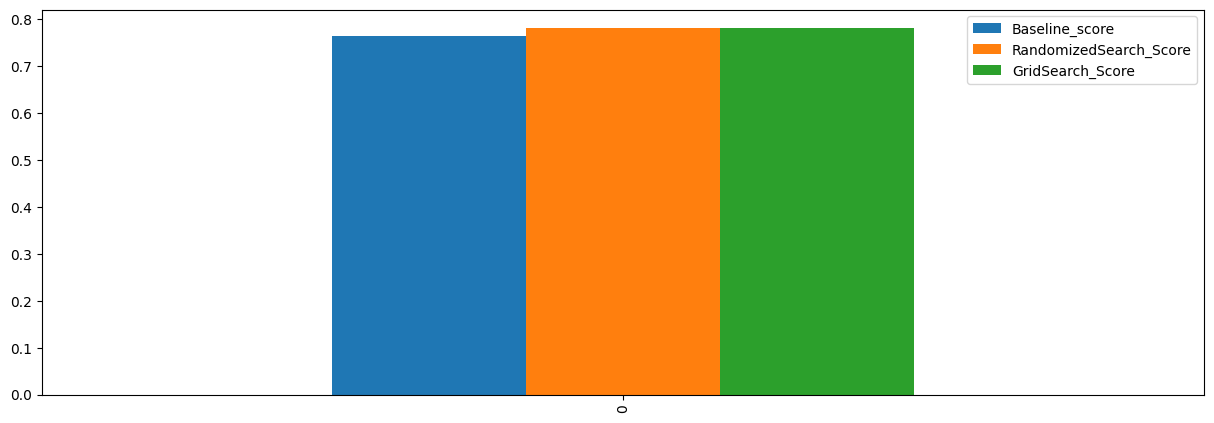

In [ ]:
# visualize results so far
results = pd.DataFrame({'Baseline_score':[AS_baseline],
                        'RandomizedSearch_Score': [AS_rs],
                        'GridSearch_Score': [AS_gs]})

results.plot.bar(figsize=(15,5));

Remark: So far the RandomizedForest has not shown impressive results. As such a different estimator will be used.